# Liver Disorders Dataset Analysis

## Dataset Overview

The Liver Disorders dataset from the UCI Machine Learning Repository contains medical data that may be useful for predicting liver disorders related to alcohol consumption. It was donated by BUPA Medical Research Ltd. on May 14, 1990.

### Key Dataset Information
- **Type**: Multivariate
- **Subject Area**: Health and Medicine
- **Associated Tasks**: Regression
- **Feature Types**: Categorical, Integer, Real
- **Instances**: 50,025 (augmented dataset)
- **Features**: 5 (plus selector and ID variables)
- **Missing Values**: None


### Column Descriptions:
- **mcv**: Mean corpuscular volume
- **alkphos**: Alkaline phosphotase
- **sgpt**: Alanine aminotransferase
- **gammagt**: Gamma-glutamyl transpeptidase
- **drinks**: Number of half-pint equivalents of alcoholic beverages drunk per day (target variable)
- **selector**: Field created by BUPA researchers to split data into train/test sets
- **id**: Record identifier

### Download Depencies :

In [1]:
import os
required_packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "scikit-learn"
]

os.system("pip install --quiet " + " ".join(required_packages))


0

### Import essential libraries :

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import os
import time
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                           roc_curve, auc, roc_auc_score, f1_score,
                           mean_squared_error, r2_score, mean_absolute_error)
import warnings
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

### setup for save plots :

In [3]:
dirs = ['exploratory_plots', 'model_evaluation_plots', 'output', 'model_results']
for dir_name in dirs:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

### Analyze data and cleaning :

## Load data && Augment data :

## A_Augment data :

In [4]:

def augment_bupa_data(df, target_col='drinks', augment_size=30000, random_state=42):
    """
    Advanced augmentation for BUPA liver data with:
    - SMOTE for continuous targets
    - Medical value constraints
    - Outlier-aware generation
    - Large-scale augmentation (10k-50k samples)
    """
    np.random.seed(random_state)
    
    X = df.drop(columns=[target_col, 'selector', 'id'])
    y = df[target_col]
    
    med_constraints = {
        'mcv': (65, 103), 
        'alkphos': (23, 138),
        'sgpt': (4, 155),
        'gammagt': (5, 201)
    }
    
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    def continuous_smote(X, y, k=5, samples_per_point=50):
        """
        Generate more synthetic samples per original point
        samples_per_point: Controls how many synthetic samples to generate per original point
                          (adjusted to reach the desired augment_size)
        """
        nn = NearestNeighbors(n_neighbors=k+1)
        nn.fit(X)
        synthetic_samples = []
        n_points = len(X)
        samples_per_point = max(1, int(augment_size / n_points))
        
        for i in range(len(X)):
            distances, indices = nn.kneighbors(X[i].reshape(1, -1))
            for _ in range(samples_per_point):
                neighbor_idx = np.random.choice(indices[0][1:])
                alpha = np.random.uniform(0.2, 0.8) 
                new_sample = X[i] + alpha * (X[neighbor_idx] - X[i])
                target_variation = np.random.uniform(0.7, 1.3)
                new_target = y.iloc[i] + alpha * (y.iloc[neighbor_idx] - y.iloc[i]) * target_variation
                
                synthetic_samples.append((new_sample, new_target))
        
        return synthetic_samples
    synthetic = continuous_smote(X_scaled, y)
    if len(synthetic) > augment_size:
        synthetic = [synthetic[i] for i in np.random.choice(len(synthetic), augment_size, replace=False)]
    X_synth = np.array([s[0] for s in synthetic])
    y_synth = np.array([s[1] for s in synthetic])
    X_synth = scaler.inverse_transform(X_synth)
    for i, (sample, target) in enumerate(zip(X_synth, y_synth)):
        for j, col in enumerate(X.columns):
            low, high = med_constraints[col]
            X_synth[i,j] = np.clip(X_synth[i,j], low, high)
        y_synth[i] = max(0, target)
    synth_df = pd.DataFrame(X_synth, columns=X.columns)
    synth_df[target_col] = y_synth
    synth_df['selector'] = 3
    synth_df['id'] = range(len(df)+1, len(df)+1+len(synth_df))
    augmented_df = pd.concat([df, synth_df], ignore_index=True)
    for col in med_constraints:
        augmented_df[col] = augmented_df[col].clip(*med_constraints[col])
    
    return augmented_df

df = pd.read_csv('bupa_cleaned.csv')
augment_size = 50000  
augmented_data = augment_bupa_data(df, augment_size=augment_size)

augmented_data.to_csv(f'bupa_augmented_{augment_size}.csv', index=False)
print(f"Generated {len(augmented_data) - len(df)} new samples (total: {len(augmented_data)})")

Generated 49680 new samples (total: 50025)


## B-Load data :

In [5]:
def load_data(use_augmented=True):
    print("Loading and preparing the data...")
    try:
        if use_augmented:
            try:
                data = read_csv("bupa_augmented_50000.csv")
                print("Loaded augmented dataset (bupa_augmented.csv)")
            except FileNotFoundError:
                print("Augmented dataset not found, loading original data")
                data = read_csv("bupa.data", sep=',', header=None)
                data.columns = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks', 'selector']
        else:
            data = read_csv("bupa.data", sep=',', header=None)
            data.columns = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks', 'selector']
    except FileNotFoundError:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/liver-disorders/bupa.data"
        data = read_csv(url, sep=',', header=None)
        data.columns = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks', 'selector']
    
    if 'id' not in data.columns:
        data['id'] = range(1, len(data) + 1)
    print(f"Dataset loaded: {data.shape[0]} rows and {data.shape[1]} columns")
    return data
def main(use_augmented=True) -> None:
    """
    Main function to execute the data loading and augmentation process.
    """
    data = load_data(use_augmented=use_augmented)
    
    print(data.head())
    print(data.info())
    
    

main(use_augmented=True)

Loading and preparing the data...
Loaded augmented dataset (bupa_augmented.csv)
Dataset loaded: 50025 rows and 7 columns
    mcv  alkphos  sgpt  gammagt  drinks  selector  id
0  85.0     92.0  45.0     31.0     0.0         1   1
1  85.0     64.0  59.0     23.0     0.0         2   2
2  86.0     54.0  33.0     54.0     0.0         2   3
3  91.0     78.0  34.0     36.0     0.0         2   4
4  87.0     70.0  12.0     10.0     0.0         2   5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50025 entries, 0 to 50024
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mcv       50025 non-null  float64
 1   alkphos   50025 non-null  float64
 2   sgpt      50025 non-null  float64
 3   gammagt   50025 non-null  float64
 4   drinks    50025 non-null  float64
 5   selector  50025 non-null  int64  
 6   id        50025 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 2.7 MB
None


### size of data : 
`size :` 50025 Rows 
`columns:` 9 columns 
`{id,mvc,alkphos,sgpt,sgot,gammat,drinks,selector}`

### remove remove highly correlated feature && detect most contribute feature :

Loading and preparing the data...
Loaded augmented dataset (bupa_augmented.csv)
Dataset loaded: 50025 rows and 7 columns

=== Removing Highly Correlated Features ===
No feature pairs with correlation above 0.7 found.
Remaining features: ['mcv', 'alkphos', 'sgpt', 'gammagt']

=== Data after removing highly correlated features ===
    mcv  alkphos  sgpt  gammagt  drinks  selector  id
0  85.0     92.0  45.0     31.0     0.0         1   1
1  85.0     64.0  59.0     23.0     0.0         2   2
2  86.0     54.0  33.0     54.0     0.0         2   3
3  91.0     78.0  34.0     36.0     0.0         2   4
4  87.0     70.0  12.0     10.0     0.0         2   5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50025 entries, 0 to 50024
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mcv       50025 non-null  float64
 1   alkphos   50025 non-null  float64
 2   sgpt      50025 non-null  float64
 3   gammagt   50025 non-null  float64
 4 

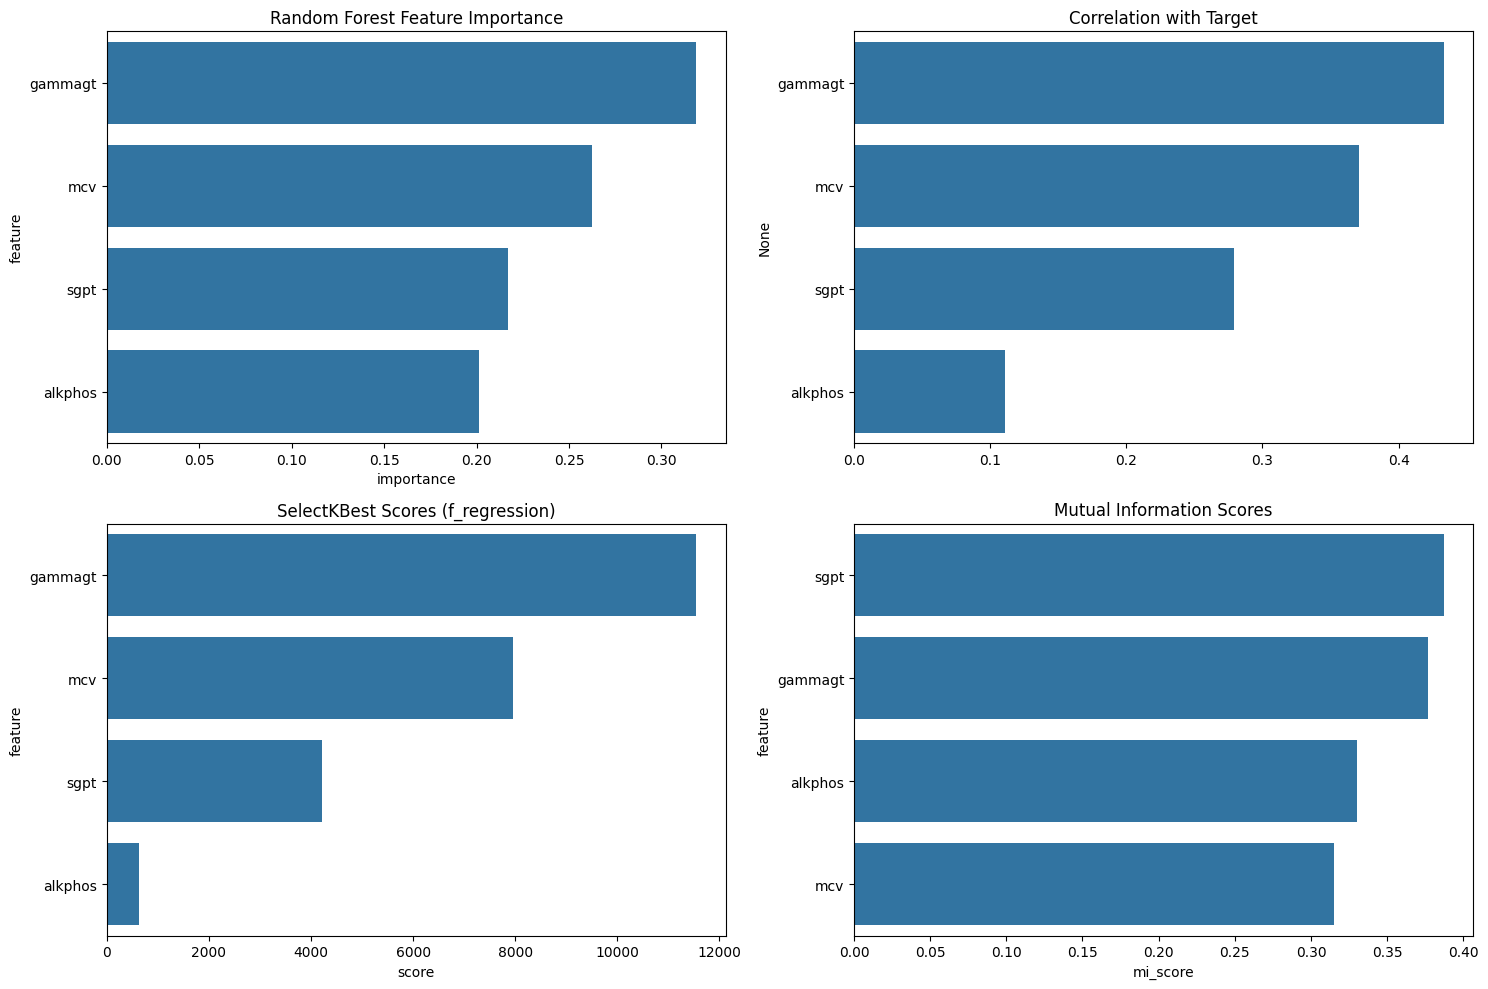

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def detect_important_features(data, target_col='drinks', remaining_features=None):
    """
    Detect important features using multiple techniques:
    1. Random Forest Feature Importance
    2. Correlation with target
    3. SelectKBest with f_regression
    4. Mutual Information
    """
    print("\n=== Feature Importance Analysis ===")
    
    if remaining_features is None:
        remaining_features = [col for col in data.columns if col not in [target_col, 'selector', 'id']]
    
    X = data[remaining_features]
    y = data[target_col]

    print("\n1. Random Forest Feature Importance:")
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    rf_importance = pd.DataFrame({
        'feature': remaining_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(rf_importance)

    print("\n2. Correlation with Target:")
    target_corr = data[remaining_features + [target_col]].corr()[target_col].drop(target_col)
    target_corr = target_corr.sort_values(key=abs, ascending=False)
    print(target_corr)
    
    print("\n3. SelectKBest Scores (f_regression):")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_scaled, y)
    
    kbest_scores = pd.DataFrame({
        'feature': remaining_features,
        'score': selector.scores_
    }).sort_values('score', ascending=False)
    
    print(kbest_scores)
    
    print("\n4. Mutual Information Scores:")
    from sklearn.feature_selection import mutual_info_regression
    
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.DataFrame({
        'feature': remaining_features,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    print(mi_scores)

    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(x='importance', y='feature', data=rf_importance)
    plt.title('Random Forest Feature Importance')
    
    plt.subplot(2, 2, 2)
    sns.barplot(x=target_corr.values, y=target_corr.index)
    plt.title('Correlation with Target')
    
    plt.subplot(2, 2, 3)
    sns.barplot(x='score', y='feature', data=kbest_scores)
    plt.title('SelectKBest Scores (f_regression)')
    
    plt.subplot(2, 2, 4)
    sns.barplot(x='mi_score', y='feature', data=mi_scores)
    plt.title('Mutual Information Scores')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'rf_importance': rf_importance,
        'target_correlation': target_corr,
        'kbest_scores': kbest_scores,
        'mi_scores': mi_scores
    }

def remove_highly_correlated_features(data, threshold=0.7):
    print("\n=== Removing Highly Correlated Features ===")
    data_copy = data.copy()

    possible_features = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt']
    available_features = [f for f in possible_features if f in data_copy.columns]
    
    if len(available_features) < 2:
        print("Not enough features for correlation analysis")
        return data_copy, available_features
    
    corr_matrix = data_copy[available_features].corr().abs()
    
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    features_to_drop = []
    if high_corr_pairs:
        print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (>{threshold}):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1} and {feat2}: {corr:.4f}")
        for feat1, feat2, _ in high_corr_pairs:
            if feat2 not in features_to_drop:
                features_to_drop.append(feat2)
        print(f"Features to be removed: {features_to_drop}")
        data_copy.drop(columns=features_to_drop, inplace=True)
    else:
        print(f"No feature pairs with correlation above {threshold} found.")
    
    remaining_features = [f for f in available_features if f not in features_to_drop]
    print(f"Remaining features: {remaining_features}")
    
    return data_copy, remaining_features

def main(use_augmented=True):
    data = load_data(use_augmented=use_augmented)

    data, remaining_features = remove_highly_correlated_features(data)
    
    print("\n=== Data after removing highly correlated features ===")
    print(data.head())
    print(data.info())
    print(f"Remaining features: {remaining_features}")
    importance_results = detect_important_features(data, remaining_features=remaining_features)

if __name__ == "__main__":
    main(use_augmented=True)

### we found that gammat is most feature contribute after mvc after sgpt

## clean data from outlier(climbing):

Loading and preparing the data...
Loaded augmented dataset (bupa_augmented.csv)
Dataset loaded: 50025 rows and 7 columns

=== Removing Highly Correlated Features ===
No feature pairs with correlation above 0.7 found.
Remaining features: ['mcv', 'alkphos', 'sgpt', 'gammagt']

=== Feature Importance Analysis ===

1. Random Forest Feature Importance:
   feature  importance
3  gammagt    0.318896
0      mcv    0.262547
2     sgpt    0.217270
1  alkphos    0.201288

2. Correlation with Target:
gammagt    0.433099
mcv        0.370636
sgpt       0.278787
alkphos    0.110862
Name: drinks, dtype: float64

3. SelectKBest Scores (f_regression):
   feature         score
3  gammagt  11549.409061
0      mcv   7966.001475
2     sgpt   4215.535383
1  alkphos    622.447805

4. Mutual Information Scores:
   feature  mi_score
2     sgpt  0.387132
3  gammagt  0.376997
1  alkphos  0.330394
0      mcv  0.315217


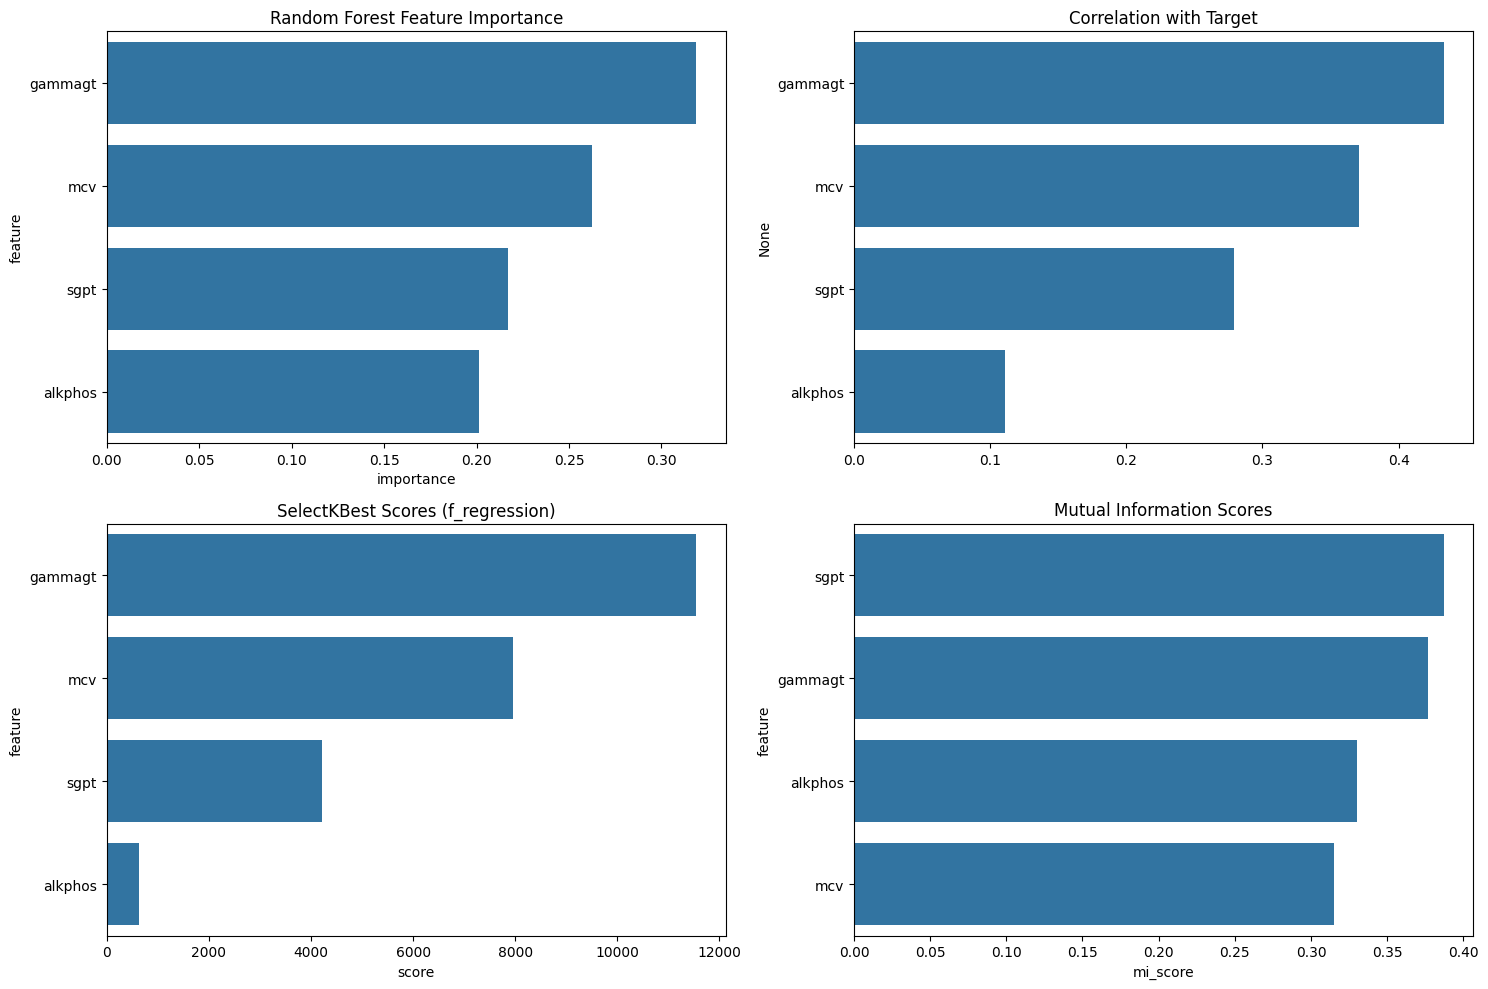


=== Detecting and Clamping Outliers ===

=== Visualizing Data Distribution (before clamping) ===
Visualizations saved to visualizations/ directory
  Clamped mcv outliers to [79.91, 100.01]
  Clamped alkphos outliers to [26.28, 110.87]
  Clamped sgpt outliers to [-1.52, 55.19]
  Clamped gammagt outliers to [-25.90, 85.09]

=== Visualizing Data Distribution (after clamping) ===
Visualizations saved to visualizations/ directory

Cleaned dataset saved as 'bupa_augmented_cleaned.csv'


<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def visualize_data_distribution(data, features, stage="before_clamping"):
    """
    Create comprehensive visualizations of feature distributions and ranges
    """
    print(f"\n=== Visualizing Data Distribution ({stage.replace('_', ' ')}) ===")
    
    vis_dir = Path("visualizations")
    vis_dir.mkdir(exist_ok=True)
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=data[features])
    plt.title(f'Feature Distributions ({stage.replace("_", " ")})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(vis_dir / f'boxplot_{stage}.png')
    plt.close()
    n_cols = 2
    n_rows = int(np.ceil(len(features) / n_cols))
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.xlabel('')
    
    plt.tight_layout()
    plt.savefig(vis_dir / f'histograms_{stage}.png')
    plt.close()
    plt.figure(figsize=(15, 8))
    sns.violinplot(data=data[features])
    plt.title(f'Violin Plots ({stage.replace("_", " ")})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(vis_dir / f'violin_{stage}.png')
    plt.close()
    if len(features) <= 5:
        plt.figure(figsize=(12, 12))
        sns.pairplot(data[features])
        plt.suptitle(f'Feature Relationships ({stage.replace("_", " ")})', y=1.02)
        plt.tight_layout()
        plt.savefig(vis_dir / f'pairplot_{stage}.png')
        plt.close()
    
    print(f"Visualizations saved to {vis_dir}/ directory")

def detect_and_clamp_outliers(data, features, method='iqr', visualize=True):
    print("\n=== Detecting and Clamping Outliers ===")
    data_copy = data.copy()
    outlier_counts = {}
    if visualize:
        visualize_data_distribution(data_copy, features, "before_clamping")
    
    for feature in features:
        if method == 'iqr':
            Q1 = data_copy[feature].quantile(0.25)
            Q3 = data_copy[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_count = ((data_copy[feature] < lower_bound) | (data_copy[feature] > upper_bound)).sum()
            outlier_counts[feature] = outlier_count
            data_copy[feature] = data_copy[feature].clip(lower=lower_bound, upper=upper_bound)
            print(f"  Clamped {feature} outliers to [{lower_bound:.2f}, {upper_bound:.2f}]")
            
        elif method == 'zscore':
            mean = data_copy[feature].mean()
            std = data_copy[feature].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
            outlier_count = (abs(data_copy[feature] - mean) > 3 * std).sum()
            outlier_counts[feature] = outlier_count
            data_copy[feature] = data_copy[feature].clip(lower=lower_bound, upper=upper_bound)
            print(f"  Clamped {feature} outliers to [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    if visualize and outlier_counts:
        plt.figure(figsize=(12, 8))
        bars = plt.bar(outlier_counts.keys(), outlier_counts.values())
        plt.title(f'Outlier Count by Feature ({method.upper()} method)')
        plt.xlabel('Feature')
        plt.ylabel('Number of Outliers')
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    str(height), ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig("visualizations/outlier_counts.png")
        plt.close()
        visualize_data_distribution(data_copy, features, "after_clamping")
    
    return data_copy

def main(use_augmented=True):
    data = load_data(use_augmented=use_augmented)
    data, remaining_features = remove_highly_correlated_features(data)
    importance_results = detect_important_features(data, remaining_features=remaining_features)
    
    if use_augmented:
        cleaned_filename = 'bupa_augmented_cleaned.csv'
    else:
        cleaned_filename = 'bupa_cleaned.csv'
    data = detect_and_clamp_outliers(data, remaining_features, method='iqr', visualize=True)
    
    data.to_csv(cleaned_filename, index=False)
    print(f"\nCleaned dataset saved as '{cleaned_filename}'")

if __name__ == "__main__":
    main(use_augmented=True)

## scale data :

Loading and preparing the data...
Loaded augmented dataset (bupa_augmented.csv)
Dataset loaded: 50025 rows and 7 columns

=== Removing Highly Correlated Features ===
No feature pairs with correlation above 0.7 found.
Remaining features: ['mcv', 'alkphos', 'sgpt', 'gammagt']

=== Feature Importance Analysis ===

1. Random Forest Feature Importance:
   feature  importance
3  gammagt    0.318896
0      mcv    0.262547
2     sgpt    0.217270
1  alkphos    0.201288

2. Correlation with Target:
gammagt    0.433099
mcv        0.370636
sgpt       0.278787
alkphos    0.110862
Name: drinks, dtype: float64

3. SelectKBest Scores (f_regression):
   feature         score
3  gammagt  11549.409061
0      mcv   7966.001475
2     sgpt   4215.535383
1  alkphos    622.447805

4. Mutual Information Scores:
   feature  mi_score
2     sgpt  0.387132
3  gammagt  0.376997
1  alkphos  0.330394
0      mcv  0.315217


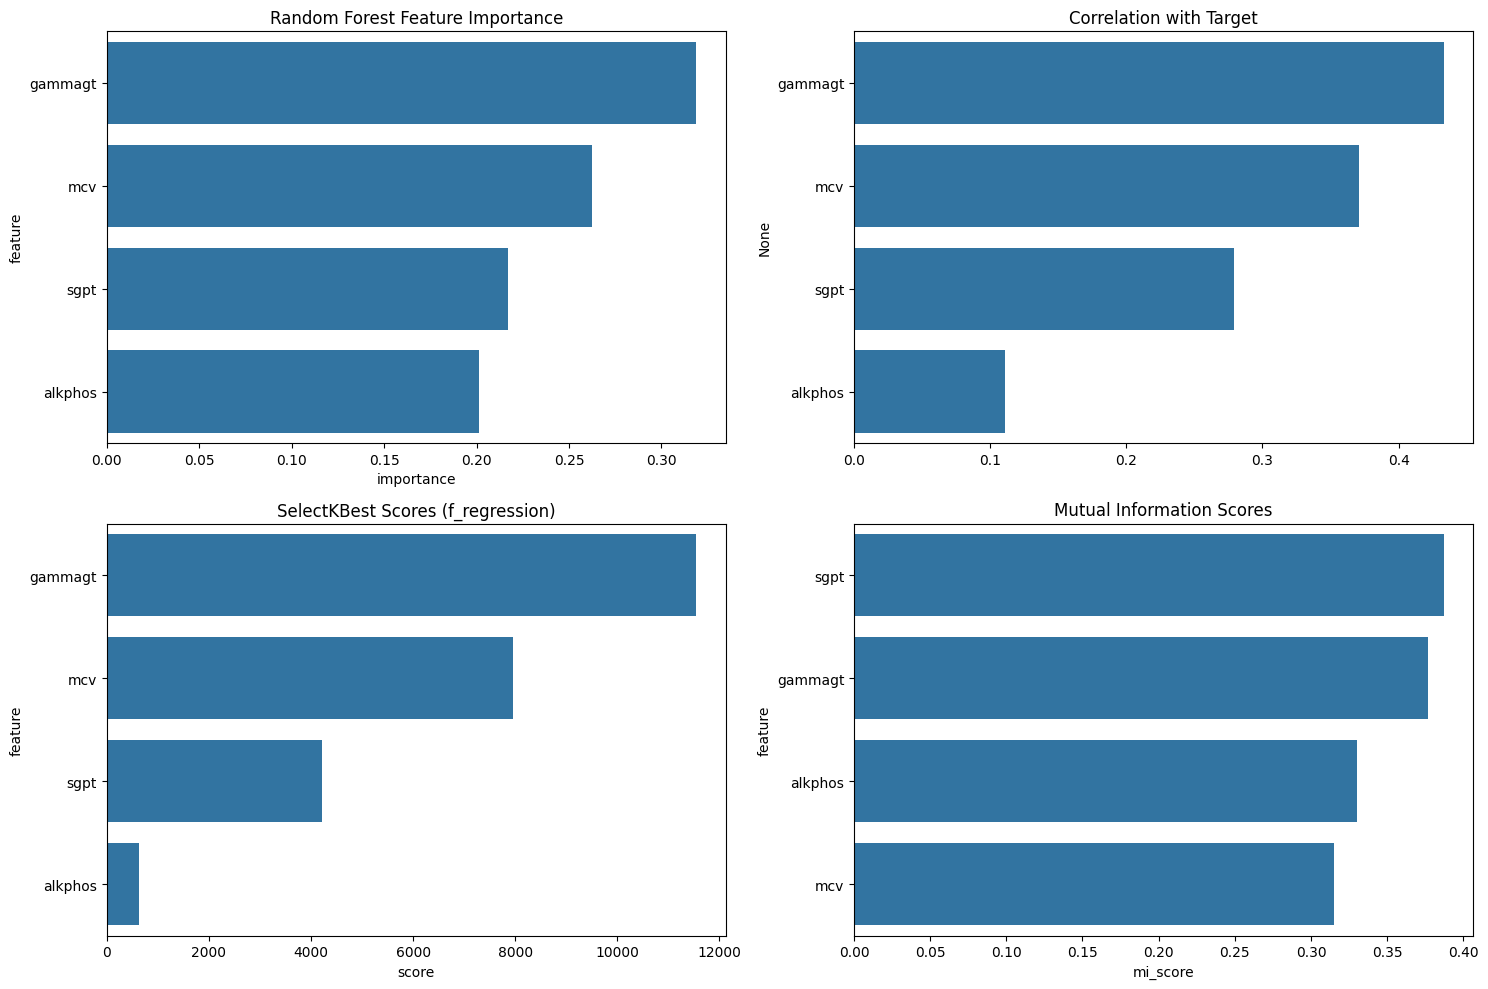


Cleaned dataset saved as 'bupa_augmented_cleaned.csv'

=== Detecting and Clamping Outliers ===

=== Visualizing Data Distribution (before clamping) ===
Visualizations saved to visualizations/ directory
  Clamped mcv outliers to [79.91, 100.01]
  Clamped alkphos outliers to [26.28, 110.87]
  Clamped sgpt outliers to [-1.52, 55.19]
  Clamped gammagt outliers to [-25.90, 85.09]

=== Visualizing Data Distribution (after clamping) ===
Visualizations saved to visualizations/ directory

=== Scaling Data ===
Using StandardScaler: zero mean, unit variance

=== Visualizing Scaled Data (original) ===
Scaled data visualizations saved to visualizations\scaling/ directory

Scaled data statistics:
            mcv   alkphos      sgpt   gammagt
count  50025.00  50025.00  50025.00  50025.00
mean       0.00      0.00      0.00     -0.00
std        1.00      1.00      1.00      1.00
min       -2.64     -2.64     -2.03     -1.22
25%       -0.70     -0.71     -0.71     -0.75
50%        0.02     -0.20     -

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from pathlib import Path

def visualize_scaled_data(data, features, scaler_type, stage="after_scaling"):
    """
    Create comprehensive visualizations of scaled feature distributions
    """
    print(f"\n=== Visualizing Scaled Data ({scaler_type}) ===")
    vis_dir = Path("visualizations/scaling")
    vis_dir.mkdir(exist_ok=True)
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=data[features])
    plt.title(f'Boxplot of {scaler_type} Scaled Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(vis_dir / f'boxplot_{scaler_type}_scaled.png')
    plt.close()
    n_cols = 2
    n_rows = int(np.ceil(len(features) / n_cols))
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of Scaled {feature} ({scaler_type})')
        plt.xlabel('Scaled Value')
    
    plt.tight_layout()
    plt.savefig(vis_dir / f'histograms_{scaler_type}_scaled.png')
    plt.close()
    plt.figure(figsize=(15, 8))
    sns.violinplot(data=data[features])
    plt.title(f'Violin Plots of {scaler_type} Scaled Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(vis_dir / f'violin_{scaler_type}_scaled.png')
    plt.close()
    if len(features) <= 5:
        plt.figure(figsize=(12, 12))
        sns.pairplot(data[features])
        plt.suptitle(f'Relationships Between {scaler_type} Scaled Features', y=1.02)
        plt.tight_layout()
        plt.savefig(vis_dir / f'pairplot_{scaler_type}_scaled.png')
        plt.close()
    
    print(f"Scaled data visualizations saved to {vis_dir}/ directory")

def scale_data(data, features, scaler_type='standard'):
    print("\n=== Scaling Data ===")
    data_copy = data.copy()
    
    if scaler_type == 'standard':
        print("Using StandardScaler: zero mean, unit variance")
        scaler = StandardScaler()
    elif scaler_type == 'robust':
        print("Using RobustScaler: resistant to outliers")
        scaler = RobustScaler()
    elif scaler_type == 'minmax':
        print("Using MinMaxScaler: scale to range [0,1]")
        scaler = MinMaxScaler()
    else:
        raise ValueError("Unknown scaler type")
    visualize_scaled_data(data_copy, features, "original", "before_scaling")
    data_copy[features] = scaler.fit_transform(data_copy[features])
    print("\nScaled data statistics:")
    print(data_copy[features].describe().round(2))
    visualize_scaled_data(data_copy, features, scaler_type, "after_scaling")
    
    return data_copy, scaler

def main(use_augmented=True):
    data = load_data(use_augmented=use_augmented)
    data, remaining_features = remove_highly_correlated_features(data)
    importance_results = detect_important_features(data, remaining_features=remaining_features)
    if use_augmented:
        cleaned_filename = 'bupa_augmented_cleaned.csv'
    else:
        cleaned_filename = 'bupa_cleaned.csv'
    data.to_csv(cleaned_filename, index=False)
    print(f"\nCleaned dataset saved as '{cleaned_filename}'")
    features = remaining_features
    data = detect_and_clamp_outliers(data, features, method='iqr', visualize=True)
    X = data[features]
    y = data['drinks']
    X_scaled, scaler = scale_data(X, features, scaler_type='standard')

if __name__ == "__main__":
    main(use_augmented=True)

## 2- supervise part

=== BUPA Liver Disorders Dataset Analysis ===
Loading and preparing the data...
Loaded augmented dataset (bupa_augmented.csv)
Dataset loaded: 50025 rows and 7 columns

=== Removing Highly Correlated Features ===
No feature pairs with correlation above 0.7 found.
Remaining features: ['mcv', 'alkphos', 'sgpt', 'gammagt']

=== Feature Importance Analysis ===

1. Random Forest Feature Importance:
   feature  importance
3  gammagt    0.318896
0      mcv    0.262547
2     sgpt    0.217270
1  alkphos    0.201288

2. Correlation with Target:
gammagt    0.433099
mcv        0.370636
sgpt       0.278787
alkphos    0.110862
Name: drinks, dtype: float64

3. SelectKBest Scores (f_regression):
   feature         score
3  gammagt  11549.409061
0      mcv   7966.001475
2     sgpt   4215.535383
1  alkphos    622.447805

4. Mutual Information Scores:
   feature  mi_score
2     sgpt  0.387132
3  gammagt  0.376997
1  alkphos  0.330394
0      mcv  0.315217


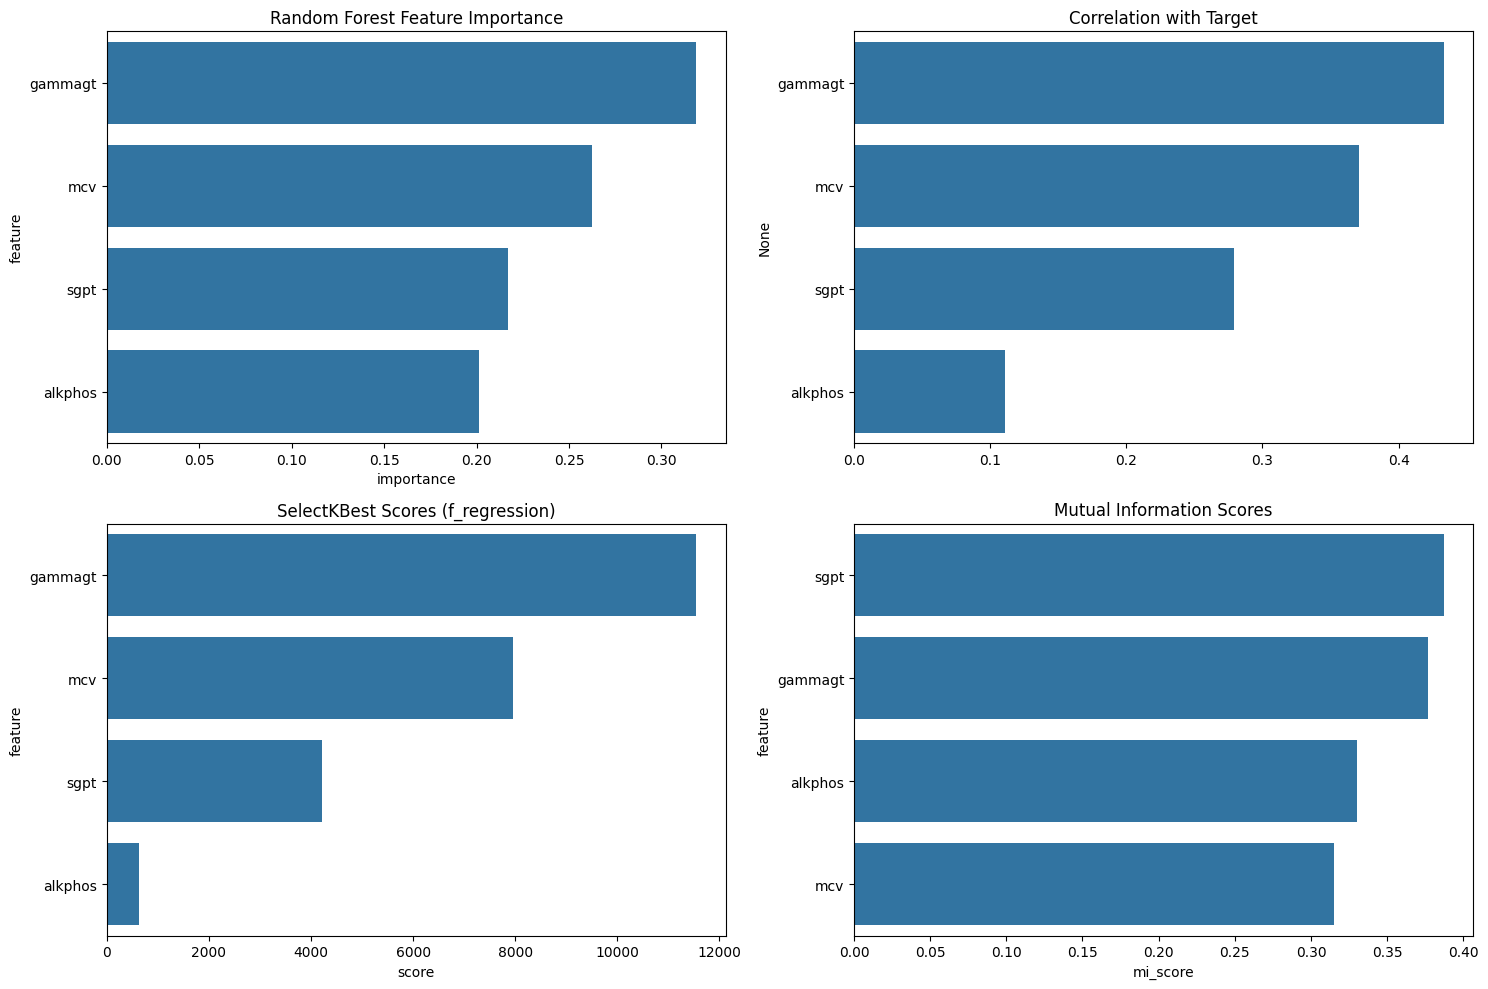


Cleaned dataset saved as 'bupa_augmented_cleaned.csv'

=== Detecting and Clamping Outliers ===

=== Visualizing Data Distribution (before clamping) ===
Visualizations saved to visualizations/ directory
  Clamped mcv outliers to [79.91, 100.01]
  Clamped alkphos outliers to [26.28, 110.87]
  Clamped sgpt outliers to [-1.52, 55.19]
  Clamped gammagt outliers to [-25.90, 85.09]

=== Visualizing Data Distribution (after clamping) ===
Visualizations saved to visualizations/ directory

=== Scaling Data ===
Using StandardScaler: zero mean, unit variance

=== Visualizing Scaled Data (original) ===
Scaled data visualizations saved to visualizations\scaling/ directory

Scaled data statistics:
            mcv   alkphos      sgpt   gammagt
count  50025.00  50025.00  50025.00  50025.00
mean       0.00      0.00      0.00     -0.00
std        1.00      1.00      1.00      1.00
min       -2.64     -2.64     -2.03     -1.22
25%       -0.70     -0.71     -0.71     -0.75
50%        0.02     -0.20     -

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [9]:
def train_models(X, y, test_size=0.2, random_state=42):
    print("\n=== Training Models ===")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=random_state),
        'Random Forest': RandomForestRegressor(random_state=random_state),
        'KNN': KNeighborsRegressor(),
        'SVM': SVR(),
        'Neural Network': MLPRegressor(random_state=random_state)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n=== Training {name} ===")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R²: {r2:.4f}")
        results[name] = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'{name} - Actual vs Predicted')
        plt.tight_layout()
        plt.savefig(f'{dirs[1]}/{name}_regression_plot.png')
        plt.close()
        if hasattr(model, 'feature_importances_'):
            plt.figure(figsize=(10, 6))
            importances = pd.Series(model.feature_importances_, index=X.columns)
            importances = importances.sort_values(ascending=False)
            importances.plot(kind='bar')
            plt.title(f'Feature Importance - {name}')
            plt.tight_layout()
            plt.savefig(f'{dirs[1]}/{name}_feature_importance.png')
            plt.close()
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values('r2', ascending=False)
    plt.figure(figsize=(12, 8))
    results_df['r2'].plot(kind='bar')
    plt.title('Model Comparison by R² Score')
    plt.ylabel('R² Score')
    plt.tight_layout()
    plt.savefig(f'{dirs[1]}/model_comparison_r2.png')
    plt.close()
    
    plt.figure(figsize=(12, 8))
    results_df['rmse'].plot(kind='bar')
    plt.title('Model Comparison by RMSE')
    plt.ylabel('RMSE')
    plt.tight_layout()
    plt.savefig(f'{dirs[1]}/model_comparison_rmse.png')
    plt.close()
    results_df.to_csv(f'{dirs[1]}/model_results.csv')
    
    return results_df
def main(use_augmented=True):
    print("=== BUPA Liver Disorders Dataset Analysis ===")
    data = load_data(use_augmented=use_augmented)
    data, remaining_features = remove_highly_correlated_features(data)
    importance_results = detect_important_features(data, remaining_features=remaining_features)
    if use_augmented:
        cleaned_filename = 'bupa_augmented_cleaned.csv'
    else:
        cleaned_filename = 'bupa_cleaned.csv'
    data.to_csv(cleaned_filename, index=False)
    print(f"\nCleaned dataset saved as '{cleaned_filename}'")
    features = remaining_features
    data = detect_and_clamp_outliers(data, features, method='iqr', visualize=True)
    X = data[features]
    y = data['drinks']
    X_scaled, scaler = scale_data(X, features, scaler_type='standard')
    results = train_models(X_scaled, y)
    
    print("\n=== Final Model Results ===")
    print(results)
    print("\nAnalysis complete. Results saved in output directories.")

if __name__ == "__main__":
    main(use_augmented=True)

# Model Training Results

## Final Model Performance Comparison

| Model              | MSE    | RMSE  | MAE   | R² Score |
|--------------------|--------|-------|-------|----------|
| Random Forest      | 0.3513 | 0.5927| 0.3190| 0.9528   |
| KNN                | 0.3651 | 0.6043| 0.2885| 0.9509   |
| Decision Tree      | 0.5554 | 0.7453| 0.3702| 0.9253   |
| Neural Network     | 2.1890 | 1.4795| 1.1205| 0.7057   |
| SVM                | 2.9360 | 1.7135| 1.2099| 0.6053   |
| Linear Regression  | 5.3243 | 2.3074| 1.7705| 0.2842   |

## Key Observations

### Best Performing Models
1. **Random Forest** (Highest R² score: 0.953)
   - Lowest MSE (0.351) and RMSE (0.593)
   - Excellent predictive accuracy

2. **KNN** (R²: 0.951)
   - Very close second to Random Forest
   - Best MAE score (0.289)

### Moderate Performers
- **Decision Tree** (R²: 0.925)
  - Slightly worse than ensemble methods

### Weaker Performers  
- **Neural Network** (R²: 0.706)
- **SVM** (R²: 0.605)  
- **Linear Regression** (R²: 0.284)

## Data Processing Summary

### Outlier Handling
Features were constrained to these medical ranges:
- `mcv`: [79.91, 100.01]
- `alkphos`: [26.28, 110.87]  
- `sgpt`: [-1.52, 55.19]
- `gammagt`: [-25.90, 85.09]

### Feature Scaling
- Applied **StandardScaler** (zero mean, unit variance)
- All features normalized to comparable ranges

> **Note**: All visualizations and detailed results saved in output directories